![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 8 - CNN Architectures</center>
### <center> Transfer Learning </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/08_CnnArchitectures/MainTransferLearning.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

For Colab users:

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/08_CnnArchitectures/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [4]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

In [5]:
from DeepLearningFramework.Training import TrainClassficationModel

### Load dataset:
https://www.kaggle.com/puneet6060/intel-image-classification

In [6]:
#-- Colab:
#-- Mount your drive before running this
if 'google.colab' in str(get_ipython()):
    !unzip "./drive/My Drive/Colab Notebooks/archive.zip"

In [7]:
#-- ImageNet statistics:
vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

oTransforms = transforms.Compose([
    transforms.Resize    (150),
    transforms.CenterCrop(150),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])

DATA_PATH = 'C:/Users/oryai/Workarea/Data/IntelSceneClassification/'
trainPath = DATA_PATH + 'seg_train/seg_train'
testPath  = DATA_PATH + 'seg_test/seg_test'

oTrainSet = torchvision.datasets.ImageFolder(root=trainPath, transform=oTransforms)
oTestSet  = torchvision.datasets.ImageFolder(root=testPath,  transform=oTransforms)
oTrainSet.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

#### Plot images:

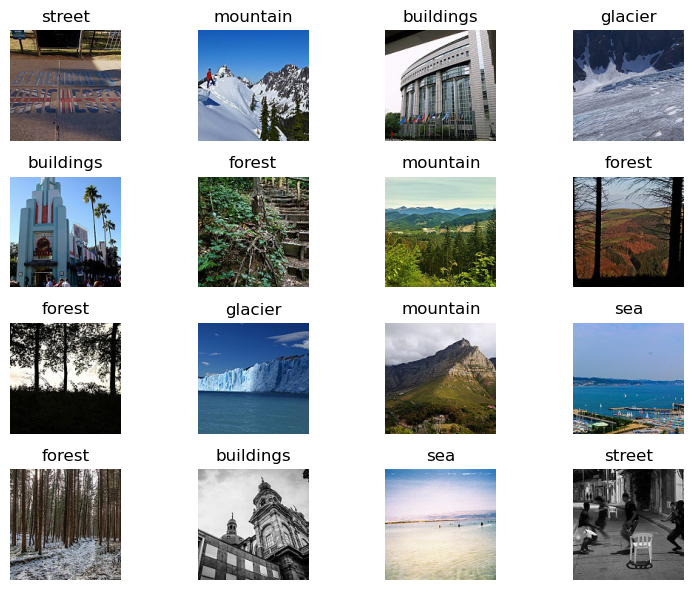

In [8]:
oTrainDL         = torch.utils.data.DataLoader(oTrainSet, batch_size=16, shuffle=True)
mImages, vLabels = next(iter(oTrainDL))

fig, _  = plt.subplots(4, 4, figsize=(8, 6))
for ii, ax in enumerate(fig.axes):
    ax.imshow    (np.clip(mImages[ii].permute(1,2,0) * vStd + vMean, 0, 1))
    ax.set_title (oTrainSet.classes[vLabels[ii]])
    ax.axis      (False)
    
plt.tight_layout()
plt.show        ()

In [9]:
#-- Data loaders:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=4, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=4, persistent_workers=True)

mX, vY    = next(iter(oTrainDL))
mX.shape

torch.Size([128, 3, 150, 150])

#### Train a new ResNet (without transfer learning):

In [10]:
def GetModel():
    return torchvision.models.resnet50(pretrained=False, num_classes=6)

torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [128, 64, 75, 75]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 75, 75]         128
├─ReLU: 1-3                              [128, 64, 75, 75]         --
├─MaxPool2d: 1-4                         [128, 64, 38, 38]         --
├─Sequential: 1-5                        [128, 256, 38, 38]        --
│    └─Bottleneck: 2-1                   [128, 256, 38, 38]        --
│    │    └─Conv2d: 3-1                  [128, 64, 38, 38]         4,096
│    │    └─BatchNorm2d: 3-2             [128, 64, 38, 38]         128
│    │    └─ReLU: 3-3                    [128, 64, 38, 38]         --
│    │    └─Conv2d: 3-4                  [128, 64, 38, 38]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 38, 38]         128
│    │    └─ReLU: 3-6                    [128, 64, 38, 38]         --
│ 

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.CrossEntropyLoss()

In [12]:
from torch.optim.lr_scheduler import OneCycleLR

nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = GetModel               ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory   = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss:  1.205 | Val loss:  8.436 | Train Accuracy:  0.564 | Val Accuracy:  0.453 | epoch time: 81.946 | <-- Checkpoint!
Epoch 001: | Train loss:  0.981 | Val loss:  1.111 | Train Accuracy:  0.636 | Val Accuracy:  0.630 | epoch time: 73.534 | <-- Checkpoint!
Epoch 002: | Train loss:  0.762 | Val loss:  2.440 | Train Accuracy:  0.713 | Val Accuracy:  0.456 | epoch time: 73.691 |
Epoch 003: | Train loss:  0.754 | Val loss:  0.879 | Train Accuracy:  0.735 | Val Accuracy:  0.688 | epoch time: 77.750 | <-- Checkpoint!
Epoch 004: | Train loss:  0.613 | Val loss:  0.693 | Train Accuracy:  0.777 | Val Accuracy:  0.742 | epoch time: 77.169 | <-- Checkpoint!
Epoch 005: | Train loss:  0.551 | Val loss:  0.568 | Train Accuracy:  0.801 | Val Accuracy:  0.771 | epoch time: 78.060 | <-- Checkpoint!
Epoch 006: | Train loss:  0.484 | Val loss:  0.491 | Train Accuracy:  0.823 | Val Accuracy:  0.822 | epoch time: 78.871 | <-- Checkpoint!
Epoch 007: | Train loss:  0.424 | Val loss:  0.420

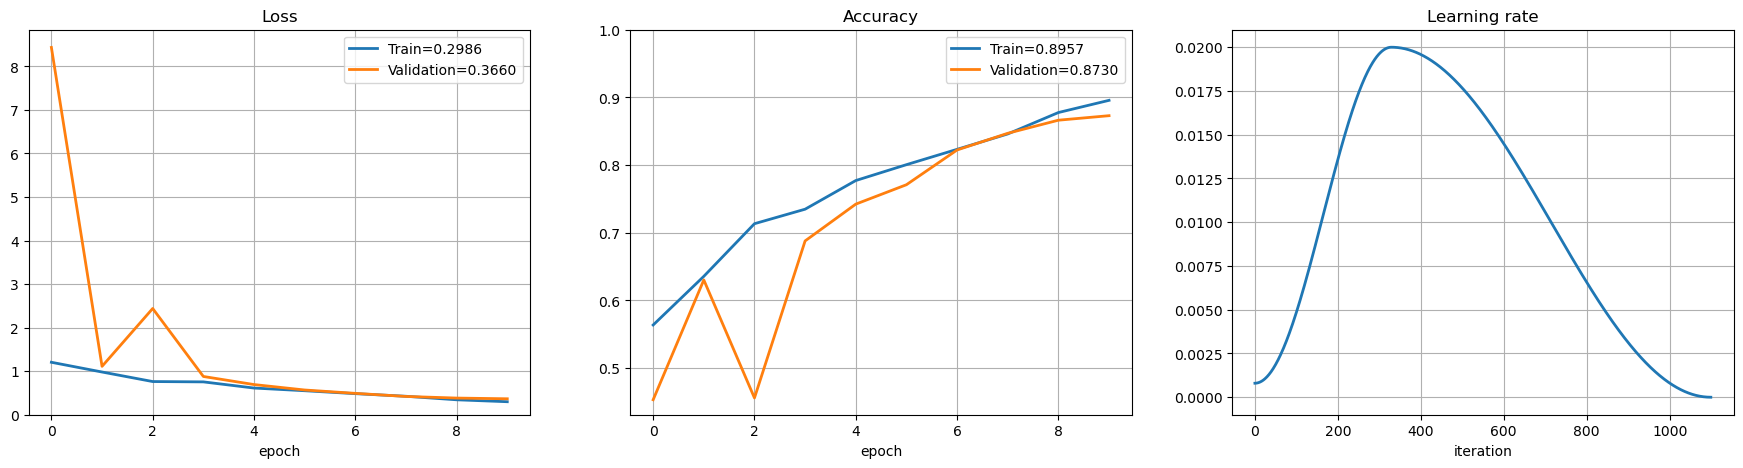

In [13]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

### Use a pretrained ResNet (transfer learning):

In [14]:
oTransforms = transforms.Compose([
    transforms.Resize    (224),
    transforms.CenterCrop(224),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])

oTrainSet = torchvision.datasets.ImageFolder(root=trainPath, transform=oTransforms)
oTestSet  = torchvision.datasets.ImageFolder(root=testPath,  transform=oTransforms)

batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

In [15]:
def GetPretrainedModel():
    oModel = torchvision.models.resnet50(pretrained=True)
    #-- freeze weights:
    for mParam in oModel.parameters():
        mParam.requires_grad = False
        
    #-- Replace classifier head:
    dIn       = oModel.fc.in_features
    oModel.fc = nn.Sequential(
        nn.Linear(dIn, 128), nn.ReLU(),
        nn.Linear(128, 6)
    )
    
    return oModel

torchinfo.summary(GetPretrainedModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [128, 64, 75, 75]         (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 75, 75]         (128)
├─ReLU: 1-3                              [128, 64, 75, 75]         --
├─MaxPool2d: 1-4                         [128, 64, 38, 38]         --
├─Sequential: 1-5                        [128, 256, 38, 38]        --
│    └─Bottleneck: 2-1                   [128, 256, 38, 38]        --
│    │    └─Conv2d: 3-1                  [128, 64, 38, 38]         (4,096)
│    │    └─BatchNorm2d: 3-2             [128, 64, 38, 38]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 38, 38]         --
│    │    └─Conv2d: 3-4                  [128, 64, 38, 38]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 38, 38]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 38, 38]  

In [17]:
nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = GetPretrainedModel     ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory   = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss:  0.437 | Val loss:  0.364 | Train Accuracy:  0.853 | Val Accuracy:  0.855 | epoch time: 57.540 | <-- Checkpoint!
Epoch 001: | Train loss:  0.360 | Val loss:  0.430 | Train Accuracy:  0.868 | Val Accuracy:  0.843 | epoch time: 44.592 |
Epoch 002: | Train loss:  0.348 | Val loss:  0.385 | Train Accuracy:  0.875 | Val Accuracy:  0.860 | epoch time: 29.539 | <-- Checkpoint!
Epoch 003: | Train loss:  0.311 | Val loss:  0.339 | Train Accuracy:  0.887 | Val Accuracy:  0.870 | epoch time: 29.819 | <-- Checkpoint!
Epoch 004: | Train loss:  0.260 | Val loss:  0.272 | Train Accuracy:  0.907 | Val Accuracy:  0.900 | epoch time: 29.049 | <-- Checkpoint!
Epoch 005: | Train loss:  0.249 | Val loss:  0.306 | Train Accuracy:  0.910 | Val Accuracy:  0.892 | epoch time: 29.554 |
Epoch 006: | Train loss:  0.216 | Val loss:  0.269 | Train Accuracy:  0.921 | Val Accuracy:  0.900 | epoch time: 29.787 | <-- Checkpoint!
Epoch 007: | Train loss:  0.201 | Val loss:  0.240 | Train Accurac

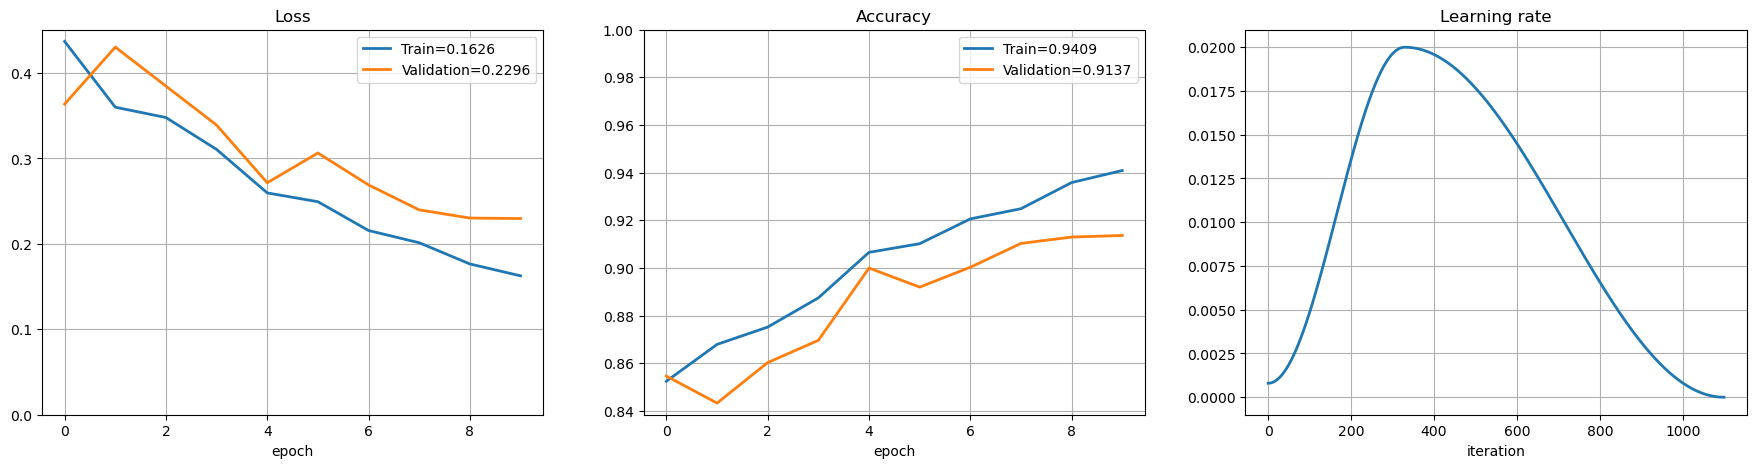

In [18]:
PlotHistory(lHistory)
plt.show   ()